In [1]:
from graphmodels.graphmodel import converte_to_format, GraphModel, concatenate_graph_specs
from database import select_dataset
from graphmodels.utils import get_X_y_from_data
from graphmodels.validation import score_model, plot_diagnostic
import pandas as pd
import numpy as np
from models.Hermen.model_BE2 import BE2_models

In [21]:
__author__ = 'Hermen'
__status__ = 'Pending Validation'

"""
TO DO.
"""
from graphmodels.graphmodel import GraphModel, concatenate_graph_specs
import pandas as pd
import numpy as np

# To check naming, confusing with demand/prod + total not total
kg_to_1000tonnes = 1e-6
day_per_year = 365
ktonnes_to_hg = 1e7

FPi_nodes = {'FLOi': {
                'type': 'input',
                'unit': '1000 tonnes',
                'name': 'Food losses per food group'
                },
             'FDKGi': {
                'type': 'input',
                'unit': 'kg/capita/day',
                'name': 'Kg food demand per day per food group'
                },
             'SSRi': {
                'type': 'input',
                'unit': '1',
                'name': 'Self-sufficiency ratio per food group',
                },
             'FDPi': {
                'type': 'variable',
                'unit': '1000 tonnes',
                'name': 'Total food production per food group',
                'computation': lambda FDKGi, Pop, FLOi, **kwargs: kg_to_1000tonnes * day_per_year * FDKGi.fillna(0) * Pop * 1e3 + FLOi.fillna(0)
                },
             'OFi': {
                'type': 'variable',
                'unit': '1000 tonnes',
                'name': 'Other food demand',
                'computation': lambda SDi, NFDi, PDi, RDi, SVi, **kwargs: SDi.fillna(0) + NFDi.fillna(0) + PDi.fillna(0) + RDi.fillna(0) + SVi.fillna(0)
                },
             'SDi': {
                'type': 'input',
                'unit': '1000 tonnes',
                'name': 'Seed demand per food group'
                },
             'NFDi': {
                'type': 'input',
                'unit': '1000 tonnes',
                'name': 'Non-food demand per food group'
                },
             'PDi': {
                'type': 'input',
                'unit': '1000 tonnes',
                'name': 'Processed demand per food group'
                },
             'RDi': {
                'type': 'input',
                'unit': '1000 tonnes',
                'name': 'Residual demand per food group'
                },
             'SVi': {
                'type': 'input',
                'unit': '1000 tonnes',
                'name': 'Stock variation per food group'
                },
             'FPi': {
                'type': 'output',
                'name': 'Food production per food group',
                'unit': '1000 tonnes',
                'computation': lambda SSRi, OFi, FDi, FDPi, **kwargs: (OFi.fillna(0) + FDi.fillna(0) + FDPi.fillna(0)) * SSRi.fillna(1)
                },
             'FDi': {
                'type': 'input',
                'unit': '1000 tonnes',
                'name': 'Feed demand per food group'
                },
             'Pop': {
                'type': 'input',
                'unit': '1000 persons',
                'name': 'Total population'
                }
        }

TCLDi_nodes = {'TCLDi': {
                  'type': 'output',
                  'name': 'Cropland demand',
                  'unit': 'ha',
                  'computation': lambda CYi, FPi, **kwargs: ktonnes_to_hg * FPi / CYi
                  },
               'CYi': {
                  'type': 'input',
                  'unit': 'hg/ha',
                  'name': 'Crop yields per crop type'
                  },
               'FPi': {
                  'type': 'input',
                  'name': 'Food production per food group',
                  'unit': '1000 tonnes'
                  },
               }

CL_nodes = {'TCLDi': {
               'type': 'input',
               'name': 'Cropland demand',
               'unit': 'ha',
               },
            'CL_corr_coef': {
               'type': 'input',
               'name': 'Correction coefficient',
               'unit': '1',
               },
            'CL_corr_intercept': {
               'type': 'input',
               'name': 'Correction intercept by country',
               'unit': '1000 ha',
               },
            'CL': {
               'type': 'output',
               'name': 'Cropland stock',
               'unit': '1000 ha',
               'computation':  lambda TCLDi, CL_corr_coef, **kwargs: TCLDi.groupby(level=['ISO', 'Year']).sum() * 1e-3 *CL_corr_coef #+ CL_corr_intercept # Strange to check !
            },
}


IL_FL_nodes = {'CL': {
                  'type': 'input',
                  'name': 'Cropland stock',
                  'unit': '1000 ha',
                  },
               'CL_baseline': {
                  'type': 'input',
                  'name': 'Cropland stock baseline',
                  'unit': '1000 ha',
                  },
               'delta_CL': {
                  'type': 'variable',
                  'name': 'Change in cropland',
                  'unit': '1000 ha',
                  'computation': lambda CL, CL_baseline, **kwargs: CL - CL_baseline
                  },
               'IL_baseline': {
                  'type': 'input',
                  'unit': '1000 ha',
                  'name': 'Inactive land baseline'
                  },
               'FL_baseline': {
                  'type': 'input',
                  'unit': '1000 ha',
                  'name': 'Forest land baseline'
                  },
               'IL': {
                  'type': 'output',
                  'name': 'Inactive land stock',
                  'unit': '1000 ha',
                  'computation': lambda delta_CL, IL_baseline, **kwargs: (IL_baseline - delta_CL).clip(lower=0) # to double check
                  },
               'FL': {
                  'type': 'output',
                  'name': 'Forest land stock',
                  'unit': '1000 ha',
                  'computation': lambda delta_CL, FL_baseline, IL_baseline, **kwargs: FL_baseline + (IL_baseline - delta_CL).clip(upper=0) # to double check
                  }
               }

BE2_nodes = {'TLA':{
               'type': 'input',
               'unit': '1000 ha',
               'name': 'Total land area'
               },
             'FL': {
               'type': 'input',
               'unit': '1000 ha',
               'name': 'Forest land stock'
               },
             'IL': {
               'type': 'input',
               'unit': '1000 ha',
               'name': 'Inactive land stock'
               },
             'R_rate': {
               'type': 'parameter',
               'unit': '%',
               'name': 'Rate of reforestation'
               },
             'FL_RF': {
               'type': 'variable',
               'name': 'Forest land stock after reforestation policy',
               'unit': '1000 ha',
               'computation': lambda FL, R_rate, IL, **kwargs: FL + 1e-2 * R_rate * IL
               },
             'BE2': {
               'type': 'output',
               'name': 'Share of forest area to total land area',
               'unit': '%',
               'computation': lambda FL_RF, TLA, **kwargs: 1e2 * FL_RF / TLA
               }
             }


FPi_model = GraphModel(FPi_nodes)
TCLDi_partial_model = GraphModel(TCLDi_nodes)
TCLDi_model = GraphModel(concatenate_graph_specs([TCLDi_nodes, FPi_nodes]))
IL_FL_model = GraphModel(IL_FL_nodes)
BE2_partial_model = GraphModel(concatenate_graph_specs([BE2_nodes, IL_FL_nodes]))
BE2_model = GraphModel(concatenate_graph_specs([BE2_nodes, IL_FL_nodes, CL_nodes, TCLDi_nodes, FPi_nodes]))

BE2_models = {
        'TCLDi_model': TCLDi_model,
        'TCLDi_partial_model': TCLDi_model,
        'FPi_model': FPi_model,
        'IL_FL_model': IL_FL_model,
        'BE2_partial_model': BE2_partial_model,
        'BE2_model': BE2_model
         }



model_df = pd.read_csv('outputs/BE2_df.csv').query('Year < 2019')
landuse = pd.read_csv('outputs/landuse.csv')
corrected_cl = pd.read_csv('outputs/cl_corr.csv')

def get_X_y_from_data(model, data_dict):
    '''TO CLEAN UP'''
    X = {key: data_dict[key] for key in model.inputs_() + model.parameters_()}
    y = {key: data_dict[key] for key in model.variables_(
    ) + model.outputs_() if key in data_dict}
    return X, y


def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code]
    return X


def fill_missing_values(df):
    return df


def df_to_data_dict(df, itemized):
    data_dict = {}

    non_item_df = df[~df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year'], columns='Variable', values='Value')
    non_item_df = fill_missing_values(non_item_df)

    if itemized != []:
        item_df = df[df.Variable.isin(itemized)].pivot(
            index=['ISO', 'Year', 'Item'], columns='Variable', values='Value')
        data_dict.update(df_to_dict(item_df))

    data_dict.update(df_to_dict(non_item_df))

    return data_dict


itemized = [
    'FDKCi', 'FPi', 'FIi', 'SVi', 'FEi',
    'FDi', 'SDi', 'FLOi', 'PDi', 'RDi', 'Food', 'FDKGi', 'NFDi',
    'SSRi', 'KKRi', 'TCLDi', 'CYi'
]

data_dict = df_to_data_dict(model_df, itemized)


data_dict.update(df_to_data_dict(landuse, itemized=[]))

data_dict['CL_baseline'] = data_dict['CL']
data_dict['IL_baseline'] = data_dict['IL']
data_dict['FL_baseline'] = data_dict['FL']
data_dict['R_rate'] = pd.Series(data=0, index=data_dict['CL_baseline'].index)

def expand_series_non_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values(
        'ISO').unique(), np.arange(2018, 2051)], names=['ISO', 'Year'])
    return df.reindex(multi_index)


def expand_series_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(
        2018, 2051), df.index.get_level_values('Item').unique()], names=['ISO', 'Year', 'Item'])
    return df.reindex(multi_index)


def apply_percent_target_projection(series, percent_target=0):
    series = series.copy()
    series = expand_series_non_itemized(series)
    series.loc[:, 2050, :] = percent_target * series.loc[:, 2018, :].values
    return series.interpolate()


def apply_itemized_percent_target_projection(series, percent_target=0):
    '''To improve: Apply item wise projection'''
    series = series.copy()
    series = expand_series_itemized(series)
    series.loc[:, 2050, :] = percent_target * series.loc[:, 2018, :].values

    return series.groupby(level=['ISO', 'Item']).apply(lambda group: group.interpolate())


def apply_annual_rate_projection(series, rate=1):
    series = series.copy()
    series = expand_series_non_itemized(series)

    year = series.loc[:, 2019:].index.get_level_values(level='Year').values

    series.loc[:, 2019:] = series.loc[:, 2018].values * rate ** (year - 2019)

    return series


def apply_constant_projection(series, constant=0):
    series = series.copy()
    series = expand_series_non_itemized(series)
    series.loc[:, 2018:] = constant

    return series


def apply_itemized_ffill_projection(series):
    series = series.copy()
    series = expand_series_itemized(series)

    return series.groupby(['ISO', 'Item']).fillna(method='ffill')


def apply_ffill_projection(series):
    series = series.copy()
    series = expand_series_non_itemized(series)

    return series.groupby(['ISO']).fillna(method='ffill')


def run_BE2_scenario(data_dict, FDKGi_target=1, FLOi_target=1, CYi_target=1, R_rate=1):

    data_dict = data_dict.copy()

    projection_dict = {
        'CYi': lambda x: apply_itemized_percent_target_projection(x, CYi_target),
        'FDKGi': lambda x: apply_itemized_percent_target_projection(x, FDKGi_target),
        'FLOi': lambda x: apply_itemized_percent_target_projection(x, FLOi_target),
        'R_rate': lambda x: apply_constant_projection(x, R_rate)
    }

    for variable, function in projection_dict.items():
        data_dict[variable] = function(data_dict[variable])

    results = BE2_models['BE2_model'].run(data_dict)
    
    # Correct the CL_baseline (find a better way to do it)
    
    results['CL_baseline'] = pd.Series(results['CL'].loc[:, 2018].values[0], index=results['CL'].index)
    
    corrected_results = BE2_models['BE2_partial_model'].run(results)
    #return results
    
    return corrected_results

def run_BE2_projection(data_dict):
    data_dict = data_dict.copy()
    
    projection_dict = {
        'FDi': lambda x: apply_itemized_ffill_projection(x),
        'SSRi': lambda x: apply_itemized_ffill_projection(x),
        'SVi': lambda x: apply_itemized_ffill_projection(x),
        'RDi': lambda x: apply_itemized_ffill_projection(x),
        'NFDi': lambda x: apply_itemized_ffill_projection(x),
        'FEi': lambda x: apply_itemized_ffill_projection(x),
        'FIi': lambda x: apply_itemized_ffill_projection(x),
        'PDi': lambda x: apply_itemized_ffill_projection(x),
        'FDi': lambda x: apply_itemized_ffill_projection(x),
        'SDi': lambda x: apply_itemized_ffill_projection(x),
        'TLA': lambda x: apply_ffill_projection(x),
        'CL_baseline': lambda x: apply_ffill_projection(x),
        'IL_baseline': lambda x: apply_ffill_projection(x),
        'FL_baseline': lambda x: apply_ffill_projection(x),
        'Pop': lambda x: apply_ffill_projection(x),
     }
     
    
    for variable, function in projection_dict.items():
        data_dict[variable] = function(data_dict[variable])

    return data_dict


In [22]:
ISO = 'FRA'
filtered_data_dict = {k: v.loc[ISO, 2018:] for k, v in data_dict.items() if k not in ['CL_corr_intercept', 'CL_corr_coef']}
filtered_data_dict['CL_corr_coef'] = 1.4
filtered_data_dict = run_BE2_projection(filtered_data_dict)
res = run_BE2_scenario(data_dict=filtered_data_dict, FDKGi_target=1.5, FLOi_target=1.5, CYi_target=1, R_rate=100)


In [32]:
res['FPi']

ISO  Year  Item                            
FRA  2018  Almonds, with shell                     1.133000
           Anise, badian, fennel, coriander        0.264000
           Apples                               1750.850847
           Apricots                              124.430780
           Areca nuts                              0.004000
                                                   ...     
     2050  Walnuts, with shell                    39.942480
           Watermelons                            25.600652
           Wheat                               36136.303232
           Yams                                    0.000000
           Yautia (cocoyam)                        0.005000
Length: 6072, dtype: float64

In [12]:
filtered_data_dict

{'CYi': ISO  Year  Item                            
 FRA  2018  Almonds, with shell                   9262.0
            Anise, badian, fennel, coriander         NaN
            Apples                              344351.0
            Apricots                             92005.0
            Areca nuts                               NaN
                                                  ...   
            Walnuts, with shell                  17000.0
            Watermelons                         187872.0
            Wheat                                67680.0
            Yams                                     NaN
            Yautia (cocoyam)                         NaN
 Name: CYi, Length: 184, dtype: float64,
 'FDKCi': ISO  Year  Item                            
 FRA  2018  Almonds, with shell                 NaN
            Anise, badian, fennel, coriander    0.0
            Apples                              7.0
            Apricots                            2.0
            Areca 

In [4]:
res['delta_CL']

ISO  Year
FRA  2018      0.000000
     2019     21.855167
     2020     43.710333
     2021     65.565500
     2022     87.420667
     2023    109.275833
     2024    131.131000
     2025    152.986167
     2026    174.841334
     2027    196.696500
     2028    218.551667
     2029    240.406834
     2030    262.262000
     2031    284.117167
     2032    305.972334
     2033    327.827500
     2034    349.682667
     2035    371.537834
     2036    393.393001
     2037    415.248167
     2038    437.103334
     2039    458.958501
     2040    480.813667
     2041    502.668834
     2042    524.524001
     2043    546.379167
     2044    568.234334
     2045    590.089501
     2046    611.944668
     2047    633.799834
     2048    655.655001
     2049    677.510168
     2050    699.365334
dtype: float64

In [5]:
res = run_BE2_scenario(data_dict=filtered_data_dict, FDKGi_target=0.5, FLOi_target=0.5, CYi_target=1, R_rate=50)

res['BE2'].loc[:, 2018:]

ISO  Year
FRA  2018    31.647755
     2019    31.667712
     2020    31.687669
     2021    31.707626
     2022    31.727583
     2023    31.747540
     2024    31.767497
     2025    31.787454
     2026    31.807411
     2027    31.827368
     2028    31.847325
     2029    31.867282
     2030    31.887239
     2031    31.907196
     2032    31.927153
     2033    31.947110
     2034    31.967067
     2035    31.987024
     2036    32.006981
     2037    32.026938
     2038    32.046895
     2039    32.066852
     2040    32.086809
     2041    32.106766
     2042    32.126723
     2043    32.146680
     2044    32.166637
     2045    32.186594
     2046    32.206551
     2047    32.226508
     2048    32.246465
     2049    32.266422
     2050    32.286379
dtype: float64

In [7]:
res['CL']

ISO  Year
FRA  2018    19049.500160
     2019    19027.644993
     2020    19005.789827
     2021    18983.934660
     2022    18962.079493
     2023    18940.224326
     2024    18918.369160
     2025    18896.513993
     2026    18874.658826
     2027    18852.803660
     2028    18830.948493
     2029    18809.093326
     2030    18787.238160
     2031    18765.382993
     2032    18743.527826
     2033    18721.672659
     2034    18699.817493
     2035    18677.962326
     2036    18656.107159
     2037    18634.251993
     2038    18612.396826
     2039    18590.541659
     2040    18568.686493
     2041    18546.831326
     2042    18524.976159
     2043    18503.120992
     2044    18481.265826
     2045    18459.410659
     2046    18437.555492
     2047    18415.700326
     2048    18393.845159
     2049    18371.989992
     2050    18350.134826
dtype: float64

In [174]:
res['FLOi'].dropna()

ISO  Year  Item                      
FRA  2018  Almonds, with shell             0.061
           Apples                         78.650
           Apricots                       20.616
           Artichokes                      9.308
           Asparagus                       5.221
                                          ...   
     2050  Vegetables, fresh nes         173.551
           Vegetables, leguminous nes      1.970
           Walnuts, with shell             2.009
           Watermelons                    32.918
           Wheat                         325.583
Name: FLOi, Length: 3366, dtype: float64

{'CYi': ISO  Year  Item                            
 FRA  2018  Almonds, with shell                   9262.0
            Anise, badian, fennel, coriander         NaN
            Apples                              344351.0
            Apricots                             92005.0
            Areca nuts                               NaN
                                                  ...   
      2019  Vegetables, fresh nes               101012.0
            Vegetables, leguminous nes           56971.0
            Walnuts, with shell                  13505.0
            Watermelons                         204844.0
            Wheat                                77428.0
 Name: CYi, Length: 270, dtype: float64,
 'FDKCi': ISO  Year  Item                            
 FRA  2018  Almonds, with shell                 NaN
            Anise, badian, fennel, coriander    0.0
            Apples                              7.0
            Apricots                            2.0
            Areca 

In [160]:
apply_itemized_percent_target_projection(filtered_data_dict['FLOi'], 1/2).loc[:, : ,'Apples']

ISO  Year
FRA  2018    78.650000
     2019    77.421094
     2020    76.192188
     2021    74.963281
     2022    73.734375
     2023    72.505469
     2024    71.276563
     2025    70.047656
     2026    68.818750
     2027    67.589844
     2028    66.360938
     2029    65.132031
     2030    63.903125
     2031    62.674219
     2032    61.445312
     2033    60.216406
     2034    58.987500
     2035    57.758594
     2036    56.529688
     2037    55.300781
     2038    54.071875
     2039    52.842969
     2040    51.614063
     2041    50.385156
     2042    49.156250
     2043    47.927344
     2044    46.698438
     2045    45.469531
     2046    44.240625
     2047    43.011719
     2048    41.782813
     2049    40.553906
     2050    39.325000
Name: FLOi, dtype: float64

In [161]:
apply_itemized_percent_target_projection(filtered_data_dict['CYi'], 1/2).loc[:, : ,'Apples']

ISO  Year
FRA  2018    344351.000000
     2019    348124.000000
     2020    342448.241935
     2021    336772.483871
     2022    331096.725806
     2023    325420.967742
     2024    319745.209677
     2025    314069.451613
     2026    308393.693548
     2027    302717.935484
     2028    297042.177419
     2029    291366.419355
     2030    285690.661290
     2031    280014.903226
     2032    274339.145161
     2033    268663.387097
     2034    262987.629032
     2035    257311.870968
     2036    251636.112903
     2037    245960.354839
     2038    240284.596774
     2039    234608.838710
     2040    228933.080645
     2041    223257.322581
     2042    217581.564516
     2043    211905.806452
     2044    206230.048387
     2045    200554.290323
     2046    194878.532258
     2047    189202.774194
     2048    183527.016129
     2049    177851.258065
     2050    172175.500000
Name: CYi, dtype: float64

In [145]:
res['CYi'].loc[:, : ,'Apricots']

ISO  Year
FRA  2018     92005.000000
     2019    109772.000000
     2020    109198.870968
     2021    108625.741935
     2022    108052.612903
     2023    107479.483871
     2024    106906.354839
     2025    106333.225806
     2026    105760.096774
     2027    105186.967742
     2028    104613.838710
     2029    104040.709677
     2030    103467.580645
     2031    102894.451613
     2032    102321.322581
     2033    101748.193548
     2034    101175.064516
     2035    100601.935484
     2036    100028.806452
     2037     99455.677419
     2038     98882.548387
     2039     98309.419355
     2040     97736.290323
     2041     97163.161290
     2042     96590.032258
     2043     96016.903226
     2044     95443.774194
     2045     94870.645161
     2046     94297.516129
     2047     93724.387097
     2048     93151.258065
     2049     92578.129032
     2050     92005.000000
Name: CYi, dtype: float64

In [143]:
res['FLOi'].loc[:, : ,'Apricots']

ISO  Year
FRA  2018    20.616
     2019    20.616
     2020    20.616
     2021    20.616
     2022    20.616
     2023    20.616
     2024    20.616
     2025    20.616
     2026    20.616
     2027    20.616
     2028    20.616
     2029    20.616
     2030    20.616
     2031    20.616
     2032    20.616
     2033    20.616
     2034    20.616
     2035    20.616
     2036    20.616
     2037    20.616
     2038    20.616
     2039    20.616
     2040    20.616
     2041    20.616
     2042    20.616
     2043    20.616
     2044    20.616
     2045    20.616
     2046    20.616
     2047    20.616
     2048    20.616
     2049    20.616
     2050    20.616
Name: FLOi, dtype: float64

In [ ]:
res['TCLDi'].loc[:, : ,'Apricots']

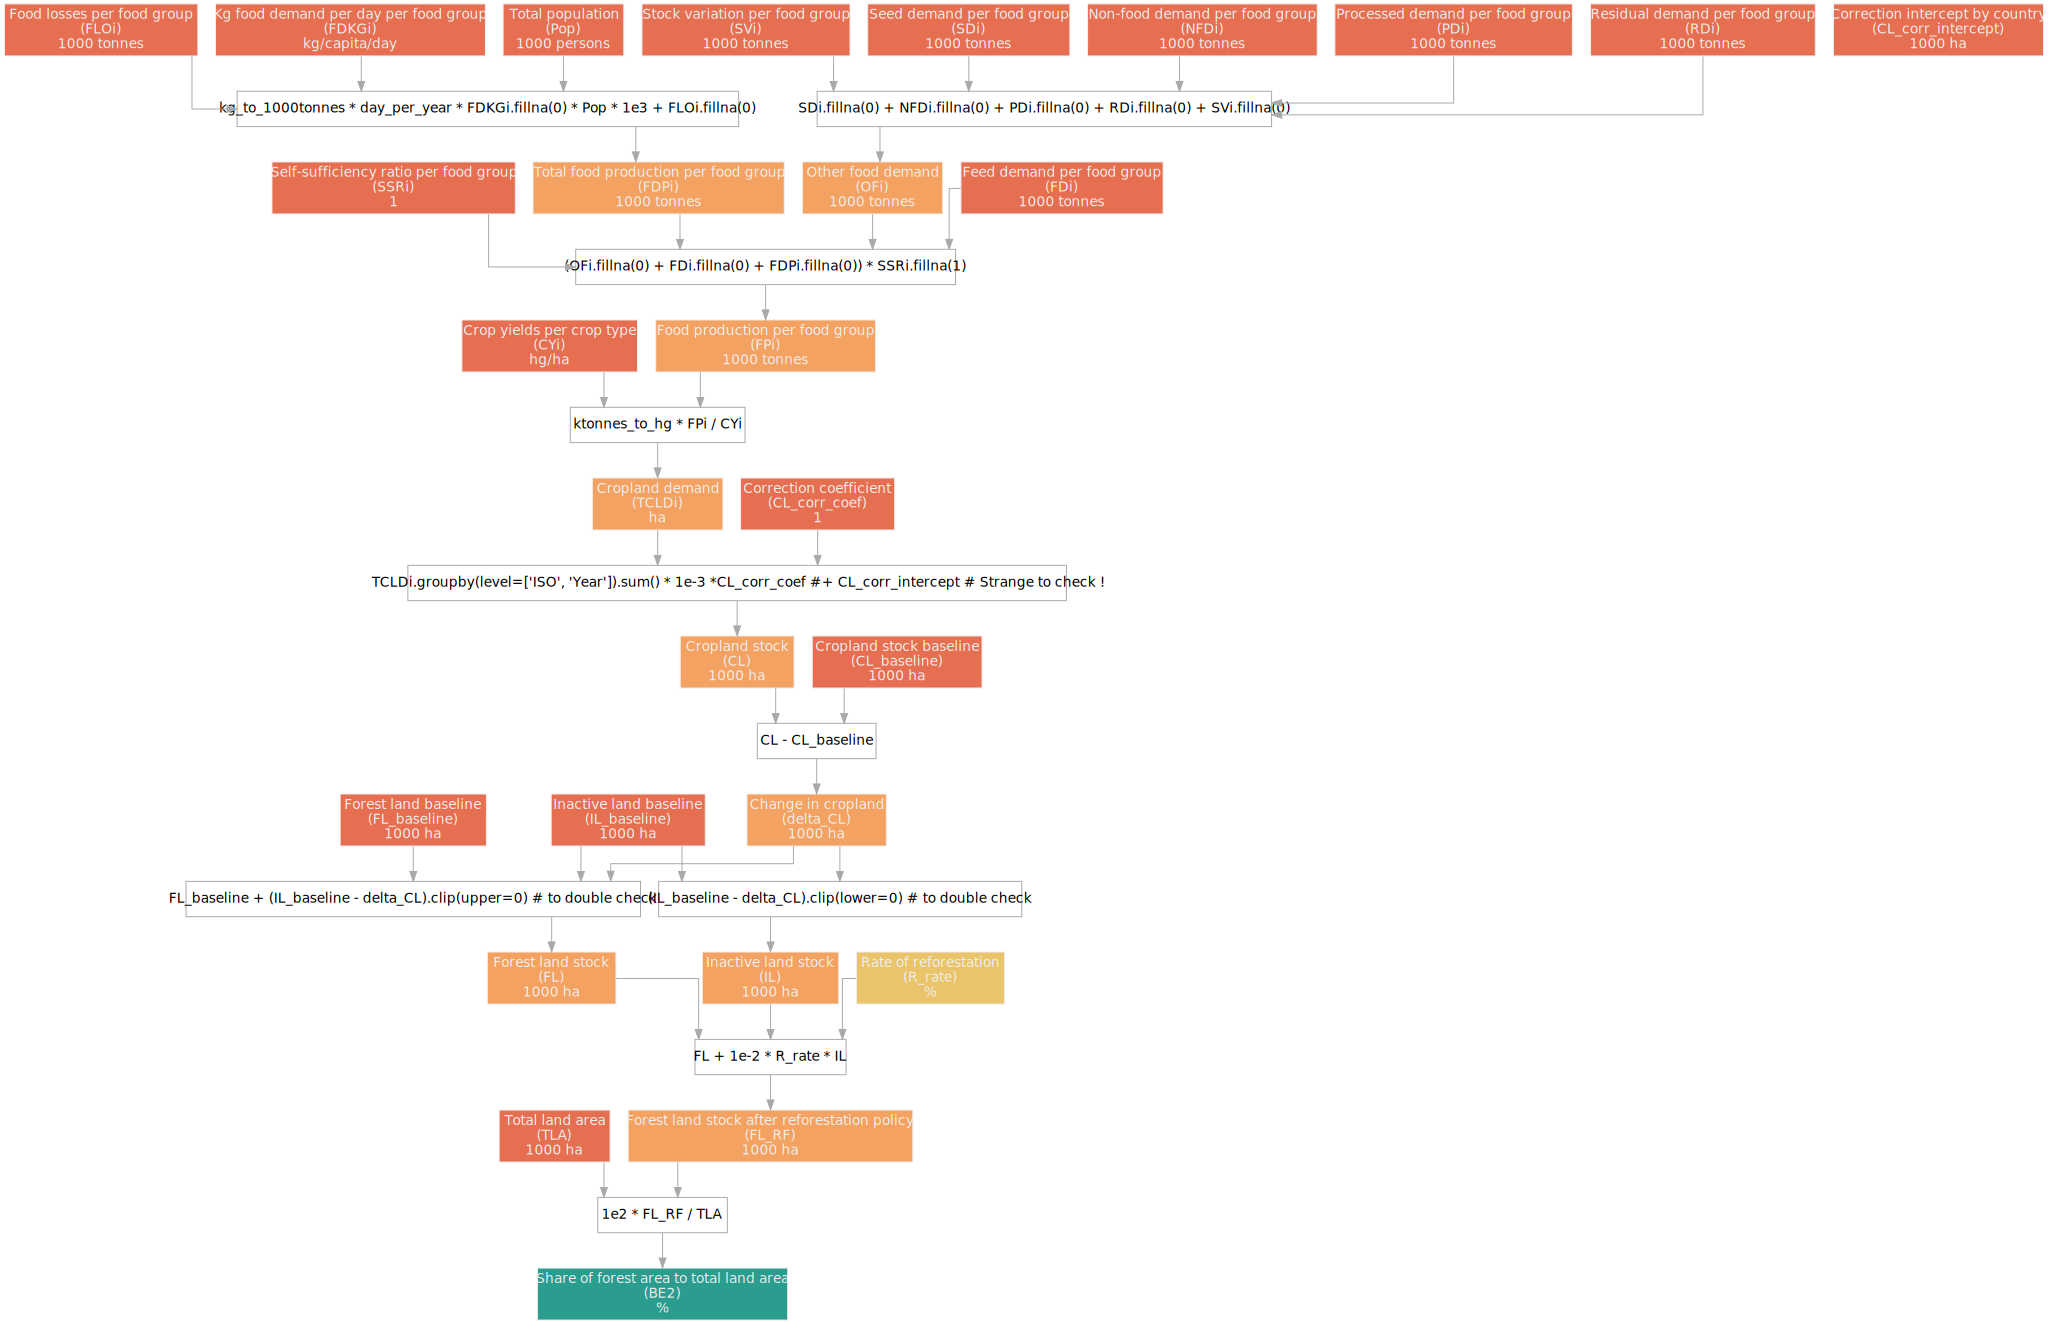

In [139]:
BE2_models['BE2_model'].draw()

In [132]:
res['FPi'].loc['FRA', :, 'Apricots']

Year
2018    124.43078
2019    124.43078
2020    124.43078
2021    124.43078
2022    124.43078
2023    124.43078
2024    124.43078
2025    124.43078
2026    124.43078
2027    124.43078
2028    124.43078
2029    124.43078
2030    124.43078
2031    124.43078
2032    124.43078
2033    124.43078
2034    124.43078
2035    124.43078
2036    124.43078
2037    124.43078
2038    124.43078
2039    124.43078
2040    124.43078
2041    124.43078
2042    124.43078
2043    124.43078
2044    124.43078
2045    124.43078
2046    124.43078
2047    124.43078
2048    124.43078
2049    124.43078
2050    124.43078
dtype: float64

In [114]:
data_dict['IL'].loc['FRA']

Year
1961         NaN
1962         NaN
1963         NaN
1964         NaN
1965         NaN
1966         NaN
1967         NaN
1968         NaN
1969         NaN
1970         NaN
1971         NaN
1972         NaN
1973         NaN
1974         NaN
1975         NaN
1976         NaN
1977         NaN
1978         NaN
1979         NaN
1980         NaN
1981         NaN
1982         NaN
1983         NaN
1984         NaN
1985         NaN
1986         NaN
1987         NaN
1988         NaN
1989         NaN
1990         NaN
1991         NaN
1992         NaN
1993         NaN
1994         NaN
1995         NaN
1996         NaN
1997         NaN
1998         NaN
1999         NaN
2000         NaN
2001    1342.300
2002    1277.100
2003    1328.000
2004    1152.900
2005    1296.600
2006    1262.400
2007    1199.800
2008     733.000
2009     660.700
2010     623.200
2011     547.300
2012     498.900
2013     486.600
2014     466.400
2015     461.100
2016     468.867
2017     485.038
2018     485.500
Name: IL,